In [15]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 

tensorflow  2.11.0
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


In [16]:
def visualize_matrix(matrix, cmap='viridis'):
    """
    matrix: Matrix to be visualized with a color mapping
    cmap: type of mapping
    ---
    It displays a matrix represented with a color scheme
    """
    D = matrix.shape[0]
    plt.imshow(matrix, cmap=cmap, extent=[0, D, 0, D], interpolation='nearest')
    plt.xticks(np.arange(D) + 0.5, np.arange(D))
    plt.yticks(np.arange(D) + 0.5, np.arange(D))
    plt.colorbar()
    plt.show()

In [17]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.boston_housing.load_data()
Y_train = np.atleast_2d(Y_train).T
Y_test = np.atleast_2d(Y_test).T
Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
Y_train = (Y_train - Y_train_mean) / Y_train_std
Y_test = (Y_test - Y_train_mean) / Y_train_std

In [7]:
def get_lower_triangular_diag(diag):
    Lambda = tf.linalg.diag(diag)
    L = tf.linalg.cholesky(Lambda)
    return L

diagonal = tf.constant([2]*13, dtype=tf.float32)
Lambda_L = get_lower_triangular_diag(diagonal)
Lambda_L
#tf.linalg.matmul(Lambda_L, tf.transpose(Lambda_L))

<tf.Tensor: shape=(13, 13), dtype=float32, numpy=
array([[1.4142135, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 1.4142135, 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.4142135, 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 1.4142135, 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 1.4142135, 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 1.4142135,
        0.       , 0.       , 0.    

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,FillTriangular,Normal,True,"(13, 13)",float64,"[[1., 0., 0...."
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Initial value of Lambda:  tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(13, 13), dtype=float64)
Initial LML:  tf.Tensor(-611.6429683950004, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=KernelAmplitude, dtype=float64, shape=[], fn="softplus", numpy=0.9748285246136018>
Final value of Lambda:  tf.Te

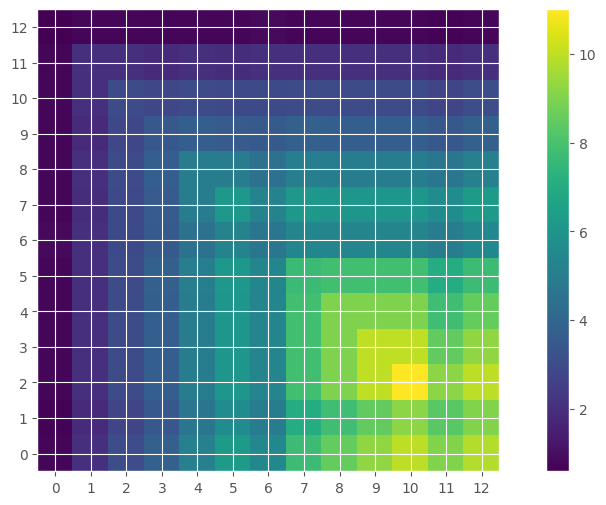

In [40]:
#Lambda = tf.constant([[1/4, 0],[0, 1/4]], dtype=tf.float64)#(1/4)*tf.eye(2, dtype=tf.float64)
D = 13
triangular_size = gpflow.utilities.bijectors.triangular_size(D)
#l = tf.zeros([triangular_size], dtype=tf.float64)
#l = tf.constant([0.5,0.,0.5], dtype=tf.float64)
#Lambda_L = tfp.math.fill_triangular(l)
diagonal = tf.constant([1]*D, dtype=tf.float32)
Lambda_L = get_lower_triangular_diag(diagonal)
LRBF = LambdaRBF(Lambda_L, 1.0)
LRBF.Lambda_L.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), scale=gpflow.utilities.to_default_float(1.))
LRBF.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), scale=gpflow.utilities.to_default_float(1.))
model = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=LRBF
,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', LRBF.variance)
print('Initial value of Lambda: ', tf.linalg.matmul(LRBF.Lambda_L, tf.transpose(LRBF.Lambda_L)))
print('Initial LML: ',model.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
Lambda_full = tf.linalg.matmul(LRBF.Lambda_L, tf.transpose(LRBF.Lambda_L))
print('-------------------------------')
print('Optimal value of kernel variance: ', LRBF.variance)
print('Final value of Lambda: ', Lambda_full)
print('Final LML: ',model.log_marginal_likelihood())
visualize_matrix(Lambda_full)

In [29]:
print('Final value of Lambda: ', Lambda_full)
#np.savetxt('test.out', tf.linalg.matmul(LRBF.Lambda_L, tf.transpose(LRBF.Lambda_L)).numpy(), fmt='%1.4e')

Final value of Lambda:  tf.Tensor(
[[ 0.59228541  0.76979001  0.7697896   0.7185233   0.77006049  0.75725403
   0.85036304  0.75472297  0.76979085  0.76979001  0.76978925  0.68810033
   0.77683367]
 [ 0.76979001  2.00049173  2.00073658  1.862519    1.99890716  1.94246569
   2.01002775  2.00381975  2.00073958  2.00073757  2.00073575  1.84059643
   2.03392789]
 [ 0.7697896   2.00073658  3.0009806   2.79140428  2.99721498  2.90096678
   2.91506448  3.02698033  3.00123081  3.00122788  3.00122521  2.78710405
   3.05845979]
 [ 0.7185233   1.862519    2.79140428  3.45825395  3.71442973  3.58816856
   3.55206755  3.76491287  3.72018282  3.72018011  3.72017764  3.47082804
   3.79582624]
 [ 0.77006049  1.99890716  2.99721498  3.71442973  4.98690702  4.95629674
   4.51438956  5.05354659  4.9946793   4.99467439  4.99466993  4.663108
   5.12336355]
 [ 0.75725403  1.94246569  2.90096678  3.58816856  4.95629674  6.16385182
   5.23713856  6.13989404  6.06973409  6.06972686  6.06972031  5.66780139
   6

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,Normal,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,Normal,True,"(13,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


Intial value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>
Intial value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])>
Initial LML:  tf.Tensor(-611.6429683950051, shape=(), dtype=float64)
-------------------------------
Optimal value of kernel variance:  <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7690897773025583>
Optimal value of kernel lengthsclaes:  <Parameter: name=softplus, dtype=float64, shape=[13], fn="softplus", numpy=
array([3.84694529, 1.00000001, 0.99992837, 2.04552305, 0.31642616,
       1.94133006, 6.37574645, 2.23834704, 0.99990645, 1.00028937,
       1.00024149, 6.45511826, 5.09843092])>
Final LML:  tf.Tensor(-483.3437220394869, shape=(), dtype=float64)


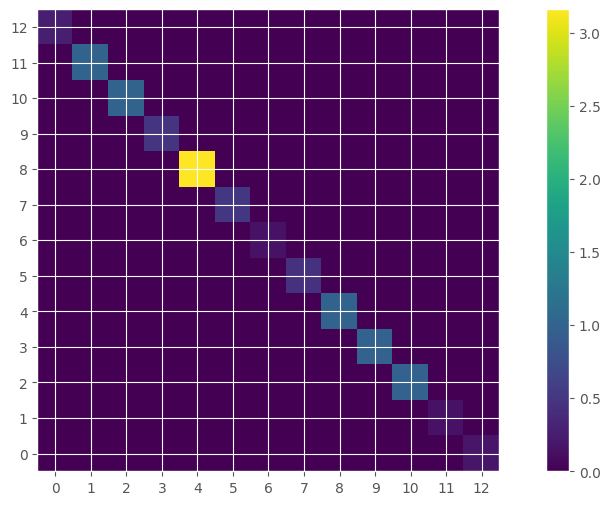

In [47]:
D = 13
k = gpflow.kernels.SquaredExponential(variance=1, lengthscales=1*np.ones(D))
k.lengthscales.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(1.), 
                                                   scale=gpflow.utilities.to_default_float(1.))
k.variance.prior = tfp.distributions.Normal(loc=gpflow.utilities.to_default_float(0.05), 
                                               scale=gpflow.utilities.to_default_float(1.))
model = gpflow.models.GPR(
    (X_train, Y_train),
    kernel=k,
)
gpflow.utilities.print_summary(model, fmt="notebook")
print('Intial value of kernel variance: ', k.variance)
print('Intial value of kernel lengthsclaes: ', k.lengthscales)
print('Initial LML: ',model.log_marginal_likelihood())
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)
Lambda_diag = tf.linalg.inv(tf.linalg.diag(k.lengthscales))
print('-------------------------------')
print('Optimal value of kernel variance: ', k.variance)
print('Optimal value of kernel lengthsclaes: ', k.lengthscales)
print('Final LML: ',model.log_marginal_likelihood())
visualize_matrix(Lambda_diag)

In [26]:
tf.linalg.diag_part(Lambda_diag)

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([0.25995624, 0.99987937, 0.99994313, 0.48889109, 3.16186519,
       0.51519453, 0.15684942, 0.44673208, 0.99995722, 0.99967178,
       0.999685  , 0.15491704, 0.19614901])>

In [31]:
tf.linalg.diag_part(Lambda_full)

<tf.Tensor: shape=(13,), dtype=float64, numpy=
array([ 0.59228541,  2.00049173,  3.0009806 ,  3.45825395,  4.98690702,
        6.16385182,  4.67214934,  7.70179226,  9.00395761, 10.00442564,
       11.0048823 ,  8.33822968,  9.81462533])>